## Description

This notebook explores the architecture with the constraint $\widetilde{Z} = \Omega Z$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange
from src.plot_utils import scatter_plot_2d
from src.utils import soft_threshold, power_method_svd
from scipy.linalg import sqrtm
import src.models as models
from src.loss import SMPC_loss, SimilarityLossDL
# plt.style.use('seaborn-whitegrid')

In [3]:
import seaborn as sns
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.0, rc={"text.usetex":True})
# sns.set_context("paper", font_scale=1.5)
# sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.axes_style("whitegrid", {'grid.linestyle': '--'},)

In [4]:
# # Default rc params
# # rc_params_orig = mpl.rcParams.copy()

# # Set rcParams
# mpl.rcParams['figure.figsize'] = (8, 6)
# # mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['lines.linewidth'] = 2.0
# mpl.rcParams['lines.markersize'] = 8
# mpl.rcParams['font.family'] = 'sans-serif'
# # mpl.rcParams['font.sans-serif'] = ''

In [4]:
seed = 42
np.random.seed(seed)
T = 100
N = 2
noise = 0.01
# A = ortho_group.rvs(dim=N)
A = np.array([[1/np.sqrt(2), -1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]])
# A = np.array([[1, 2], [2, 1]])
A = A / np.linalg.norm(A, axis=0, keepdims=True)
K = A.shape[1]
runtime_params = {
    'K': K,
    'N': N,
    'T': T,
}
A

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

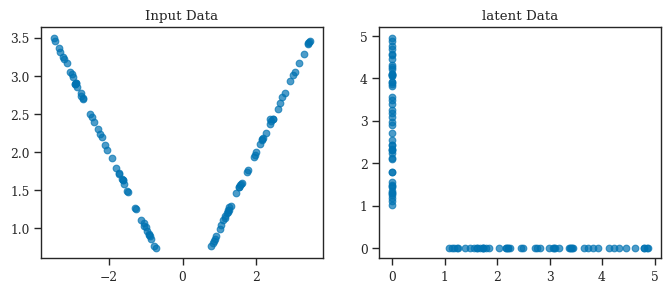

In [5]:

def gen_Zs(K, M, low=0, high=5, seed=42):
    
    np.random.seed(seed)
    num_points_per_class = M // K
    Z = np.zeros((K, M))
    for i in range(K):
        Z[i, i*num_points_per_class:(i+1)*num_points_per_class] = np.random.uniform(low, high, size=(num_points_per_class,))
        
    return Z

true_Z = gen_Zs(K, T, low=1, high=5, seed=seed) 
X = A @ true_Z + noise * np.random.randn(N, T)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0], scatter = scatter_plot_2d(X[0], X[1], ax=ax[0], title='Input Data', alpha=0.7)
fig.show()

# fig, ax = plt.subplots()
ax[1], scatter = scatter_plot_2d(true_Z[0], true_Z[1], ax=ax[1], title='latent Data', alpha=0.7)



Text(0.5, 1.0, 'Opt_W')

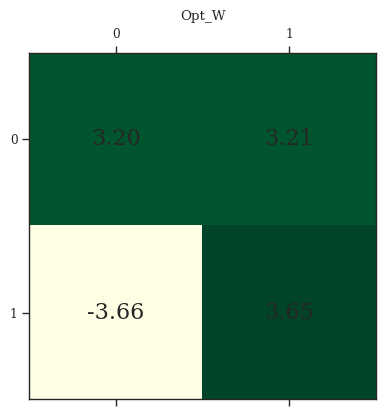

In [6]:
def write_matrix_values(mat, ax):
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=16)
        
        
fig, ax = plt.subplots(figsize=(6, 4.5))

W_opt = 1/T * (true_Z @ X.T)
ax.matshow(W_opt, cmap='YlGn'); ax.grid(False)
write_matrix_values(W_opt, ax); ax.set_title(r'Opt_W')


### Dictionary Learning with Omega updated

In [12]:

exp_params = {
    'optimizer': {
        'max_epochs': 50000,
        'neuron_max_updates':20,
        'lr': 0.1,
        'lr_neuron': 0.01,
        'lr_param': 0.1,
        'lr_param_Omega': 0.001
    },
    'runtime': runtime_params,
    'model': {
        'lam': 0.0002,
        'rho': 0.5,
        'omega': 1.0,
        # 'step': 1e-6
    }
}

Hinv_true = la.inv((1/T) * (true_Z @ true_Z.T) +  exp_params['model']['omega'] * np.eye(true_Z.shape[0]))
true_Omega = sqrtm(Hinv_true)
true_step = 0.05 / power_method_svd(torch.from_numpy(true_Omega).float(), device='cpu').item()
print(true_step)

exp_params['model']['step'] = true_step

# Define model
model = models.SMPC(exp_params)

# Define loss
loss_fn = SimilarityLossDL(T=T, lam=exp_params['model']['lam'], rho=exp_params['model']['rho'])

true_loss = SMPC_loss(T=T, lam=exp_params['model']['lam'], rho=exp_params['model']['rho'])


plot_values = {
    'loss': {
        'sim': [],
        'sparsity': [],
        'const_term': [],
        'total': []
    },
    'true_loss': {
        'sim': [],
        'sparsity': [],
        'total': []
    },
    'neurons': [],
    'parameters': [], 
    'symm_Omega': [],
    'Hinv_diff': [],
    'Hinv_th': []
}


pbar = trange(exp_params['optimizer']['max_epochs'])

for i in pbar:
    
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_Z(X, fixed=False)

    

    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_latent()

        
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_error()


    
    # Update parameters
    model.update_parameters(X, fixed=False) # update W, M
    model.update_Omega(const=False)
    

    
    plot_values['neurons'].append(model.return_neurons())  
    plot_values['parameters'].append(model.return_parameters())
    
    total, sim, sparsity, const_term = loss_fn.sim_loss_L1_DL_ver2(X, model.latent, model.Z, model.Omega)
    
    plot_values['symm_Omega'].append(np.linalg.norm(model.Omega - model.Omega.T))
    
    plot_values['Hinv_th'].append(np.linalg.norm(model.H_inv_th - model.Hinv))
    plot_values['Hinv_diff'].append(np.linalg.norm(Hinv_true - model.Hinv))
    
    plot_values['loss']['total'].append(total); plot_values['loss']['sim'].append(sim); plot_values['loss']['sparsity'].append(sparsity); plot_values['loss']['const_term'].append(const_term)
    
    # H = la.inv(model.H_inv_th)
    H = la.inv(model.Hinv)
    total, sim, sparsity = true_loss.L1_loss(X, model.latent, H)
    plot_values['true_loss']['total'].append(total); plot_values['true_loss']; plot_values['true_loss']['sim'].append(sim); plot_values['true_loss']['sparsity'].append(sparsity)
    
    pbar.set_description(f"Loss: {total:.2f}")
    
    # if (i==20): 
    #     break
    





0.27643779953599185


Loss: -23.48: 100%|██████████| 50000/50000 [01:07<00:00, 740.37it/s]


In [13]:
# Generate plots
Ahat = (X @ model.latent.T @ model.Hinv) / model.T
Ahat_n = Ahat / np.linalg.norm(Ahat, axis=0, keepdims=True)
Xhat = Ahat_n @ model.latent


error_norm = np.array([np.mean(np.linalg.norm(plot_values['neurons'][i]['error'], axis=0, keepdims=True)) for i in range(len(plot_values['neurons']))])



In [14]:
from datetime import datetime
import os
from pathlib import Path

In [15]:
results_folder = Path('results/' + f'{datetime.now().strftime("%m-%d")}/' + f'{datetime.now().strftime("%H-%M")}/')
os.makedirs(results_folder, exist_ok=True)

In [24]:
model.Omega.shape

(2, 2)

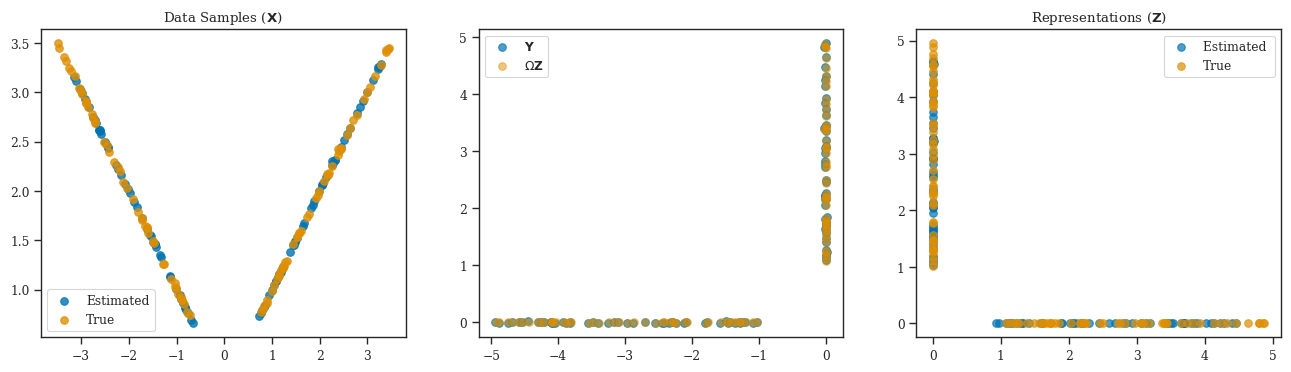

In [29]:
# Plot neurons
omega_z = model.Omega @ model.latent
fig, axs = plt.subplots(1, 3,  figsize=(16,4))
ax = axs[1]
ax, scatter = scatter_plot_2d(model.Z[0], model.Z[1], ax=ax, alpha=0.7, s=30, label='$\mathbf{Y}$'); ax.set_title(r'$\mathbf{Y}$')
ax, scatter = scatter_plot_2d(omega_z[0], omega_z[1], ax=ax, alpha=0.5, s=30, label=r'$\Omega \mathbf{Z}$'); ax.legend()

ax = axs[-1]
ax, scatter = scatter_plot_2d(np.abs(model.latent[0]), np.abs(model.latent[1]), ax=ax, label='Estimated ', alpha=0.7, s=30);
ax, scatter = scatter_plot_2d(true_Z[0], true_Z[1], ax=ax, label='True', alpha=0.7, s=30); ax.set_title('Representations ($\mathbf{Z}$)')
ax.legend()
# axs[2].plot(error_norm, label='$||\epsilon||$'); axs[2].set_xlabel('Epochs'); axs[2].legend()
ax = axs[0]
ax, scatter = scatter_plot_2d(Xhat[0], Xhat[1], ax=ax, label=r'Estimated', alpha=0.8, s=30)
ax, scatter = scatter_plot_2d(X[0], X[1], ax=ax, label=r'True', alpha=0.8, s=30)
ax.set_title('Data Samples ($\mathbf{X}$)')
ax.legend()
fig.savefig(results_folder / 'learned_representations.pdf', bbox_inches='tight')
# plt.savefig('../figures/smpc_reconstruction.pdf', bbox_inches='tight')
fig.show()



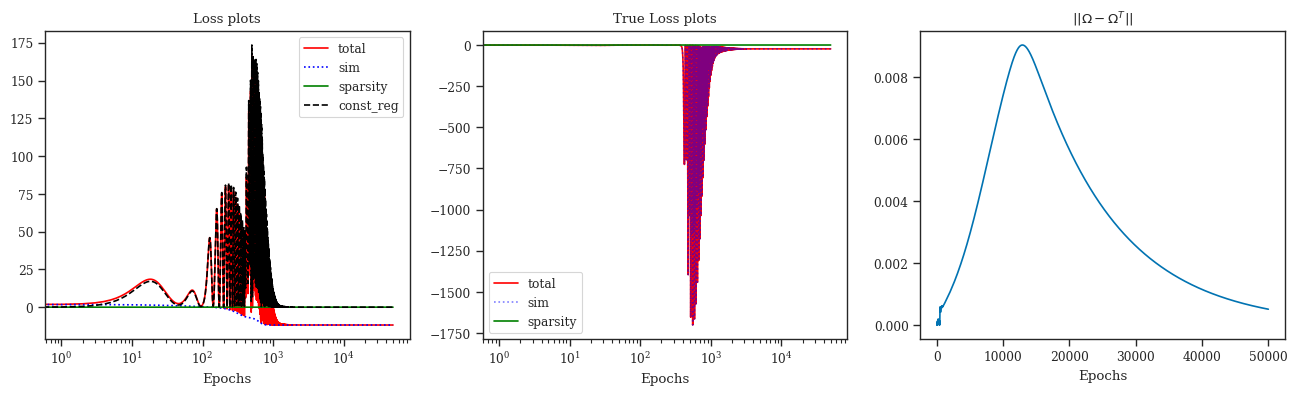

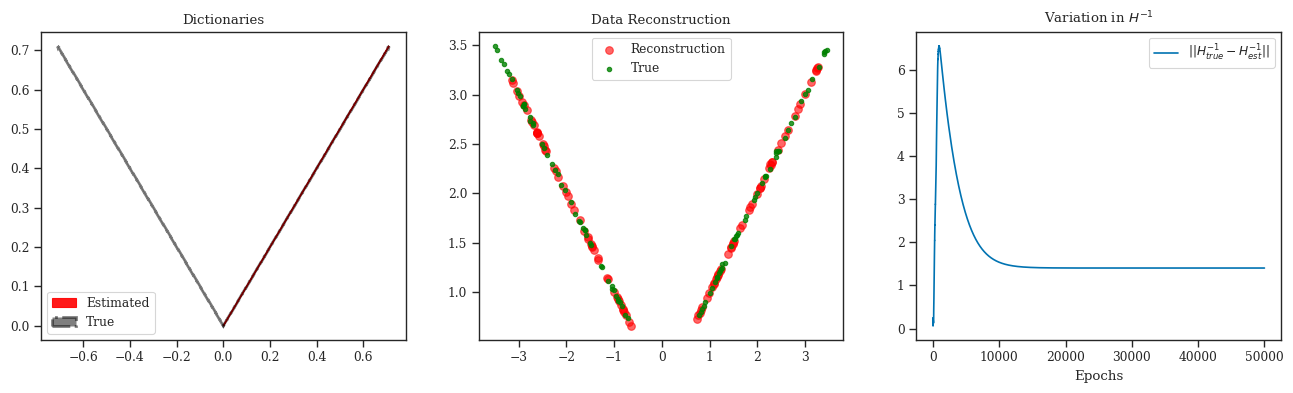

In [17]:

fig, axs  = plt.subplots(1, 3, figsize=(16, 4))
ax = axs[0]

ax.plot(plot_values['loss']['total'], label='total', c='r')
ax.plot(plot_values['loss']['sim'], label='sim', c='b', linestyle='dotted')
ax.plot(plot_values['loss']['sparsity'], label='sparsity', c='g')
ax.plot(plot_values['loss']['const_term'], label='const_reg', c='k', linestyle='dashed')
ax.set_title('Loss plots')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Epochs')


ax = axs[1]
ax.plot(plot_values['true_loss']['total'], label='total', c='r')
ax.plot(plot_values['true_loss']['sim'], label='sim', c='b', linestyle='dotted', alpha=0.5)
ax.plot(plot_values['true_loss']['sparsity'], label='sparsity', c='g')
ax.set_title('True Loss plots')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Epochs')

ax = axs[2]
ax.plot(plot_values['symm_Omega'], label=r'$||\Omega - \Omega^T||$'); ax.set_title(r'$||\Omega - \Omega^T||$'); ax.set_xlabel('Epochs')
fig.savefig(results_folder / 'loss_plots.pdf', bbox_inches='tight', format='pdf')



fig, axs = plt.subplots(1, 3, figsize=(16,4))
ax = axs[0]
ax.arrow(0, 0, np.abs(Ahat_n[0,0]), np.abs(Ahat_n[1,0]) , color='r', label='Estimated', alpha=0.9)
ax.arrow(0, 0, np.abs(Ahat_n[0,1]), np.abs(Ahat_n[1,1]), color='r', alpha=0.9)
ax.arrow(0, 0, A[0,0], A[1,0], color='k', label='True', alpha=0.5, ls='-.', lw=2)
ax.arrow(0, 0, A[0,1], A[1,1], color='k', alpha=0.5, ls='-.', lw=2)
ax.legend()
ax.set_title('Dictionaries')
fig.show()
ax = axs[1]
ax, scatter = scatter_plot_2d(Xhat[0], Xhat[1], ax=ax, label=r'Reconstruction', alpha=0.6, c='r', s=30)
ax, scatter = scatter_plot_2d(X[0], X[1], ax=ax, label=r'True', alpha=0.8, c='g', s=10)
ax.legend()
ax.set_title('Data Reconstruction')

ax = axs[2]
# ax.plot(plot_values['Hinv_th'], label=r'$||H^{-1}_{th} - H^{-1}||$'); ax.set_xlabel('Epochs')
ax.plot(plot_values['Hinv_diff'], label=r'$||H^{-1}_{true} - H^{-1}_{est}||$'); ax.set_title(r'Variation in $H^{-1}$'); ax.set_xlabel('Epochs')
fig.savefig(results_folder / 'reconst.pdf', bbox_inches='tight', format='pdf')
ax.legend()



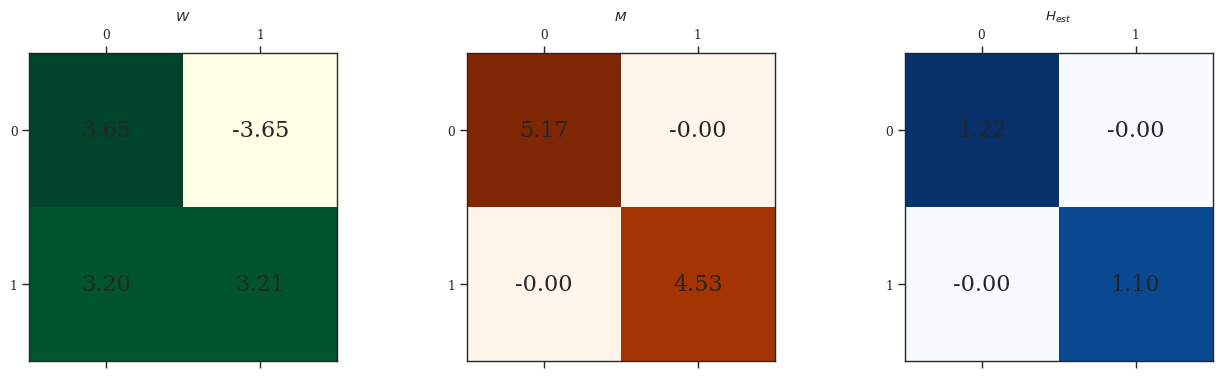

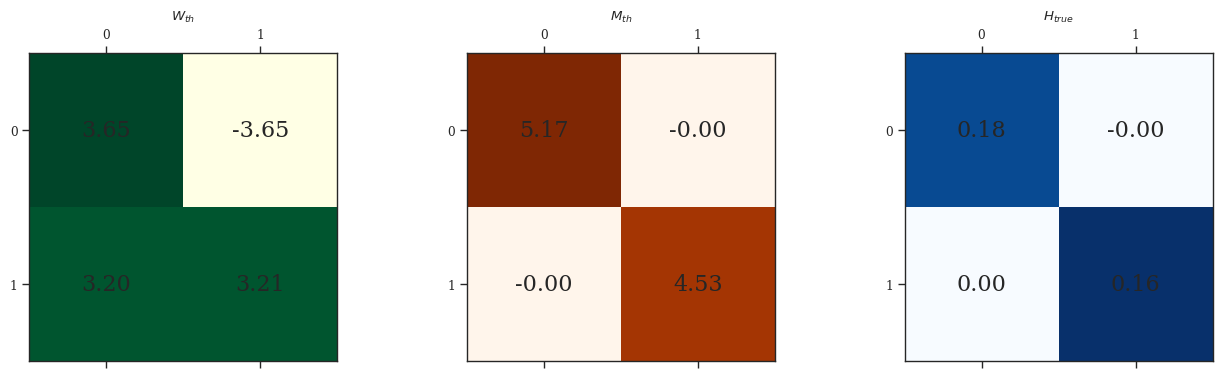

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
ax = axs[0]
ax.matshow(model.W, cmap='YlGn'); ax.grid(False); ax.set_title(r'$W$'); write_matrix_values(model.W, ax)
ax = axs[1]
ax.matshow(model.M, cmap='Oranges'); ax.grid(False); ax.set_title(r'$M$'); write_matrix_values(model.M, ax)
ax = axs[2]
H_pred = model.Omega.T @ model.Omega
ax.matshow(model.Omega.T @ model.Omega, cmap='Blues'); ax.grid(False); ax.set_title(r'$H_{est}$'); write_matrix_values(H_pred, ax)
fig.savefig(results_folder / 'parameter_plots_est.pdf', bbox_inches='tight', format='pdf')

fig, axs = plt.subplots(1, 3, figsize=(16,4))
W_th = (1/model.T) * (model.Z @ X.T)
ax = axs[0]
ax.matshow(W_th, cmap='YlGn'); ax.grid(False); ax.set_title(r'$W_{th}$'); write_matrix_values(W_th, ax)
M_th = (1/model.T) * (model.Z @ model.Z.T)
ax = axs[1]
ax.matshow(M_th, cmap='Oranges'); ax.grid(False); ax.set_title(r'$M_{th}$'); write_matrix_values(M_th, ax)
true_H = ((1/model.T) * true_Z @ true_Z.T) + model.omega * np.eye(true_Z.shape[0])
ax = axs[2]
ax.matshow(true_H, cmap='Blues'); ax.grid(False); ax.set_title(r'$H_{true}$'); write_matrix_values(la.inv(true_H), ax)
fig.savefig(results_folder / 'parameter_plots_th.pdf', bbox_inches='tight', format='pdf')